![jakarta](images/banner.png)

## Group 
<i ><font size="+1">Stefan Sack, Stefano Barison</font></i>

## Category
<font size="+1">Qiskit Default</font>

## Table of Contents
* [1 Introduction](#1---introduction)
    * [1.1 Classical simulation](#11---classical-simulation)
* [2 Solution proposal](#2--solution-proposal)
    * [2.1 Trotterization comparison](#21---trotterization-comparison)
    * [2.2 Circuit compression](#22-circuit-compression)
        * [2.2.1 Compression of Trotter step](#221-compression-of-trotter-step)
        * [2.2.2 Yang - Baxter Equivalence (YBE)](#222yang---baxter-equivalence-ybe)
    * [2.3 Projected Variational Quantum Dynamics (pVQD)](#23-projected-variational-quantum-dynamics-pvqd)
    * [2.4 Error mitigation](#24-error-mitigation)
        * [2.4.1 Qubit routing](#241--qubit-routing)
        * [2.4.2 Zero Noise Extrapolation (ZNE)](#242-zero-noise-extrapolation-zne)
        * [2.4.3 Removal of unphysical bitstrings](#243-removal-of-unphysical-bitstrings)
* [3 Execution](#3-execution)
    * [3.1 On noisy simulator](#31-noisy-simulator)
        * [3.1.1 Submit jobs](#311-submit-jobs)
        * [3.1.2 Collect results and compute fidelity](#312-collect-results-and-compute-fidelity)
    * [3.2 On hardware](#32-hardware)
        * [3.2.1 Submit jobs](#321-submit-jobs)
        * [3.2.2 Collect results and compute fidelity](#322-collect-results-and-compute-fidelity)

## Notebook styling

In [1]:
# Add some custom styling to the notebook
# Run this cell to add a custom style to the notebook (highly recommended since it's very nice)

from IPython.core.display import HTML
def css_styling():
    styles = open("notebook_style.css", "r").read() 
    return HTML(styles)

css_styling()

## What's in this submission? 

The present notebook contains the proposed solution for the IBM Open Science Prize 2021.

However, the submission contains other files:

- the `trotter_function.py` file contains all the functions related to the Trotter decomposition of the evolution operator. Since in the notebook we will incrementally optimize the proposed circuit, we decided to group all the functions in a separate file
- the `optimization_functions.py` contains a set of function that will be used to optimize our circuits. The functions contained and their usage will be explicitly stated in the notebok when needed.
- the `pvqd_logfile.dat` contains data about the Trotterization compression method that we don't show explicitly in the notebook
- the `images` directory, as the name suggests, contains the images that are used in the notebook
- the `notebook_style.css` contains the style guide for this notebook, like colors of titles, bullets, text-alignement and so on 

## What packages do we need to install?

As requested by the guideline of the challenge, this notebook contains only functions that are either written from scratch using Qiskit or that are only one `pip install` away.

Here we list the libraries needed to fully run the notebook:

- the Qiskit library via `pip install qiskit`
- the Mitiq library  via `pip install mitiq`, make sure that the version installed is `>= 0.11.1` 
- the ipywidget library to visualize the final Qiskit table via `pip install ipywidgets`


Other libraries are considered already installed, like jupyter notebook, matplotlib, numpy, ... as represent the common usage of Python. 

For convenience we have added `requirements.txt` which contains an installation instruction for all the libraries that we used to successfully run the notebook. It can be installed executing the cell below.

In [ ]:
# Execute to install the libraries that are required to successfully run the notebook 
%pip install -r requirements.txt

### DONE: 

 - <s>little introduction?</s>
 - <s>better explanation of ZNE</s>
 - <s>better explanation of "bitstring removal"</s>
 - <s>banner for the intro</s>
 - <s>image for YBE</s>
 - <s>citation for YBE conjecture</s>
 - <s>better documentation of the code</s>
 - <s>add pVQD image</s>
 - <s>add pVQD explanation</s>
 - <s>explain decision on qubit routing</s>
 - <s>add better explanation in Trotter functions</s>
 - <s>Documentation of error mitgation functions</s>
 - <s>Add citation for ZNE </s>
 - <s>Make result retrival also work for noisy simulation</s>
 - <s>hide pVQD optimization log and put it in pVQD_log.txt</s>
 - <s>add Qiskit version information at the end (just like they do in their site)</s>
 - <s>description of what files contains</s>
 - <s> Fix active links color</s>
 - <s> YBE rerun with 0.9995</s>
 - <s>Rerun the pVQD to state the runtime </s>
 
### TO DO:
 
 - <s>Test ZNE on simulator</s>
 - <s>Fix ZNE documentation</s>
 - Add requirements.txt (pip freeze > requirements.txt) 

 
 - Remove the TODO list
 
 

# 1 - Introduction  <a class="anchor" id="1---introduction"></a>

Quantum simulation is one of the first envisioned application of quantum computing and has been proved to be of polynomial complexity on devices making use of quantum resources.

Due to its potential impact on many different areas of physics, chemistry and materials science, significant amounts of research have been devoted to such application.

However, the realisation of an universal quantum simulator remains far in the future due to combined effect of limited connectivity and noisy gates: the noise sets a maximum number of operations that can be performed without affecting the fidelity, while the sparse connection graph among qubits increases the total number of physical operations that must be performed to implement an algorithm.

This challenge required us to consider the $XXX$-Heisenberg spin model 

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) 
\end{equation}
$$
and significantly improve its state-of-the-art simulation.

In particular, the challenge is to simulate the time evolution of the Heisenberg model with $N=3$ spins arranged in a line and $J=1$ up to $t=\pi$ using at least 4 Trotter steps.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1.1 - Classical simulation <a class="anchor" id="11---classical-simulation"></a> 
We start by showing some classical simulation of the model.

Once we have the Hamiltonian matrix of the system  $H_{\text{Heis3}}$, the time evolution operator that solves the Schrödinger equation can be obtained by matrix exponentiation
$$
\begin{equation}
U_{\text{Heis3}}(t) = e^{-it H_\text{Heis3}} = \exp\left(-it H_\text{Heis3}\right) \, .
\end{equation}
$$

This operation is very accurate, but the computational cost scales exponentially with the system size on a classical computer.

As the system contains only 3 spins, the classical simulation will be the blueprint to evaluate the quality of our quantum simulation.

We start by creating the function that returns the Heisenberg Hamiltonian:

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

and then the function that return the time evolution operator up to time $t$

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian 
# for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

We will use this operator to compute the evolution of the state $|110\rangle$ up to $t=\pi$.

Here below we compute and plot the probability of remaining in $|110\rangle$ state over an array of time points, namely

$$
\begin{equation}
p_{110}(t) =|\langle 110 |e^{-it H_\text{Heis3}}|110\rangle|^2
\end{equation}
$$

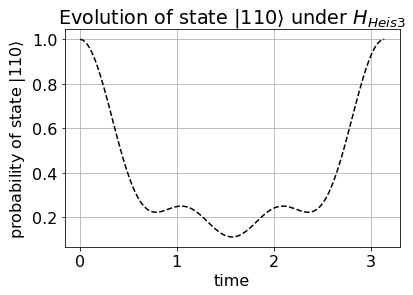

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# 2- Solution proposal <a class="anchor" id="2--solution-proposal"></a>

We have already said that on a quantum computer the simulation of quantum dynamics is proven to be of polynomial complexity.
This is true provided that we employ the Trotter-Suzuki approximation of the time evolution operator: given an Hamiltonian which can be written has a sum of local terms $H=\sum_l H_l$, we can write

$$
e^{-i\sum_{l}H_l t} = \bigg( \prod_{l} e^{-iH_{l}\frac{t}{n}}\bigg) ^{n} + O\bigg( \frac{t^2}{n}\bigg)
$$

meaning that the time evolution operator can be approximated as a product of local operators, that can be implemented efficiently as quantum gates acting on the qubits.
The error of this approximation can be decreased arbitrarily provided $n$ sufficiently big.
Unfortunately, the depth of such a circuit is of $O(n)$, which means that with current error rates and no error correction schemes at the end the result will be completely dominated by noise.

We are thus required to find a trade-off between simulation accuracy and circuit depth and use state of the art techniques to mitigate the noise acting on the system.

More information on how quantum computers can be used to simulate quantum systems can be found in \[1\].

In our case, we are required to use at least $4$ steps ($n\geq4$) to time evolve the state $|110\rangle$ to time $t=\pi$ under $H_{\text{heis3}}$.

For this reason, we start from simply considering the Trotter time evolution for different values of $n\geq4$ to assess the accuracy of this approximation.

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) 

### 2.1 - Trotterization comparison <a class="anchor" id="21---trotterization-comparison"></a> 

We will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                     import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer       import QasmSimulator
from qiskit.tools.monitor       import job_monitor
from qiskit.circuit             import Parameter, ParameterVector
from qiskit.quantum_info        import Statevector, Pauli
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import PauliOp, SummedOp, CircuitSampler, StateFn

In [7]:
## We have included a file called "trotter_function.py"
## that contains different implementations of a Trotter step that we will use in this notebook

# In this case, we import the standard Trotterization of the XXX Hamiltonian 
# as indicated in Fig. 4a of arXiv:1907.03505v2
from trotter_functions import Heisenberg_Trotter

We start from the naive approach to Trotterization, that requires implementing every gate $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$ separately, as indicated in Fig. 4a of \[1\]. For 3 spins and $n$ Trotter steps this has the form:

$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n}
$$

where the superscript $(i,j)$ indicates on which spins (qubits) the operator is acting on.

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3*, 1900052 (2020)](https://doi.org/10.1002/qute.201900052) 

In [8]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8 and 12 Trotter steps
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

# We loop over different number of Trotter steps
for n in probs_110_trott.keys():
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter(num_qubits=3,trotter_steps=n,t=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[n].append(trott_ovp)
    print(str(n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


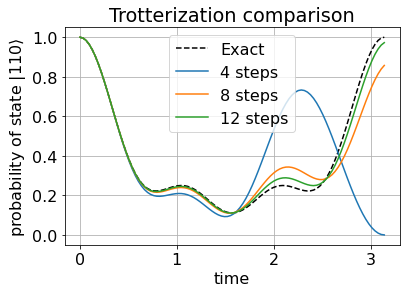

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, with an increasing number of Trotter steps we get closer and closer to the exact simulation.

However, in the present form a single Trotter step requires 12 CNOTs, resulting in a total of 48 CNOTs for $n=4$ and 144 CNOTs for $n=12$, a circuit significantly too deep for current hardware. This forces us to compress the greatest Trotterization accuracy into the shortest possible circuit, before even considering to evalute the circuit on hardware.

## 2.2 Circuit compression <a class="anchor" id="22-circuit-compression"></a> 


### 2.2.1 Compression of Trotter step <a class="anchor" id="221-compression-of-trotter-step"></a> 

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $e^{-it(XX+YY+ZZ)}$ rotation presented in in Fig. 4b of \[1\].

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48. 

---
\[1\] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3*, 1900052 (2020)](https://doi.org/10.1002/qute.201900052) 

In [10]:
# From the same file as before, we import the compressed Trotterization of Fig. 4b of arXiv:1907.03505v2
from trotter_functions import Heisenberg_Trotter_compressed

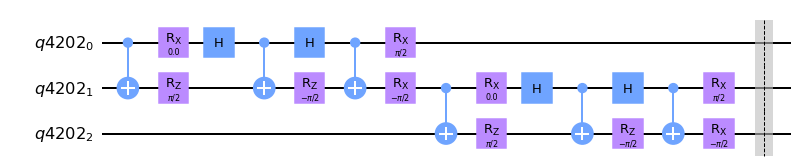

In [11]:
## An an example of a single Trotter step using the optimized decomposition

compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=1,t=t,target_time=np.pi/4)
compression_example.decompose().decompose().draw(output='mpl')

To show that the two decompositions are equivalent, let us simulate again the system with $4$ steps up to $t=\pi$.

In [12]:
probs_110_trott_c = []
for sim_t in ts:
    # Initialise the circuit
    trott_qr_c = QuantumRegister(3)
    trott_qc_c = QuantumCircuit(trott_qr_c)
    trott_qc_c.x([1,2])
    
    # Append the Trotterization
    trott_step_c = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,t=t,target_time=sim_t).to_instruction()
    trott_qc_c.append(trott_step_c, [trott_qr_c[0], trott_qr_c[1], trott_qr_c[2]])
    
    # Measure the overlap with |110> As in the first case
    trott_wfn_c = CircuitStateFn(trott_qc_c)
    trott_ovp_c = np.abs((~initial_state@trott_wfn_c).eval())**2
    probs_110_trott_c.append(trott_ovp_c)

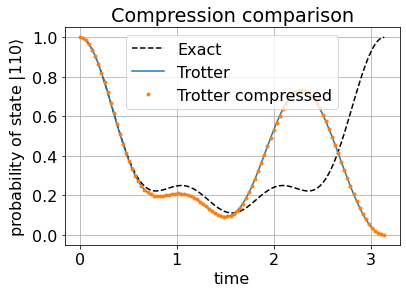

In [13]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott[4],color="C0",label="Trotter")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Compression comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, the two circuits give exactly the same probability at all times!

### 2.2.2 Yang - Baxter Equivalence (YBE) <a class="anchor" id="222yang---baxter-equivalence-ybe"></a>

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further!

To this end we will be using the Yang-Baxter Equation (YBE) \[2\] which has recently been used by \[3\] to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way (Fig.3 in \[3\]):

![YBE](images/YBE.png)

In our case $\mathcal{R}=e^{-it(XX+YY+ZZ)}$ which is one rotation gate acting on a pair of qubits.

The current circuit with $24$ CNOT gates has the following structure:

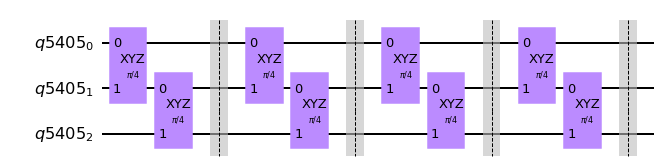

In [14]:
compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,t=t,target_time=np.pi)
compression_example.decompose().draw(output='mpl')

The YBE tells us that we can "mirror" the gates the whenever we encounter three $\mathcal{R}$ terms. 

Repeating this procedure allows to bring multiple $\mathcal{R}$ onto the same pair of qubits, they can then be combined into a single rotation with a new rotational angle.

The procedure is outlined in the figure below, in our case this allow us to propose a circuit with only $15$ CNOT gates instead of $24$ since each $\mathcal{R}$ contains 3 CNOT gates.

![YBE](images/YBE_on_circuit.png)

Unfortunately, the paper doesn't present an analytical relationship between the Trotter circuit and the YBE-compressed circuit rotational angles when considering the XXX Hamiltonian. It is however conjectured to generally exist for gates with such alternating pattern (see \[4\]).

Since there is no known analytical expression for the new angles of the compressed circuit in our case, we propose to find them variationally.

We want to highlight that we are not going to use these parameters in the final circuit.
The aim of this section is to demonstrate that at every time $t$ a set of parameters can be found in order for the YBE circuit to be equivalent to the Trotter one. Even if the relationship is not known analytically, we find it variationally. 

---
\[2\] Jimbo M. , *Introduction to the Yang-Baxter Equation*, [International Journal of Modern Physics A, vol. 04, no.15](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503)

\[3\] Gulania et al, *Quantum time dynamics of 1D-Heisenberg models employing the Yang-Baxter equation for circuit compression*, [arXiv:2112.01690](https://arxiv.org/abs/2112.01690)

\[4\] Bassman et al, *Constant-Depth Circuits for Dynamic Simulations of Materials on Quantum Computers*, [arXiv:2103.07429](https://arxiv.org/abs/2103.07429)

In [15]:
# Import the YBE circuit 
# The function returns the circuit corresponding to the YBE compression of a 4 Trotter steps circuit in 3 spins 
from trotter_functions import Heisenberg_YBE_variational

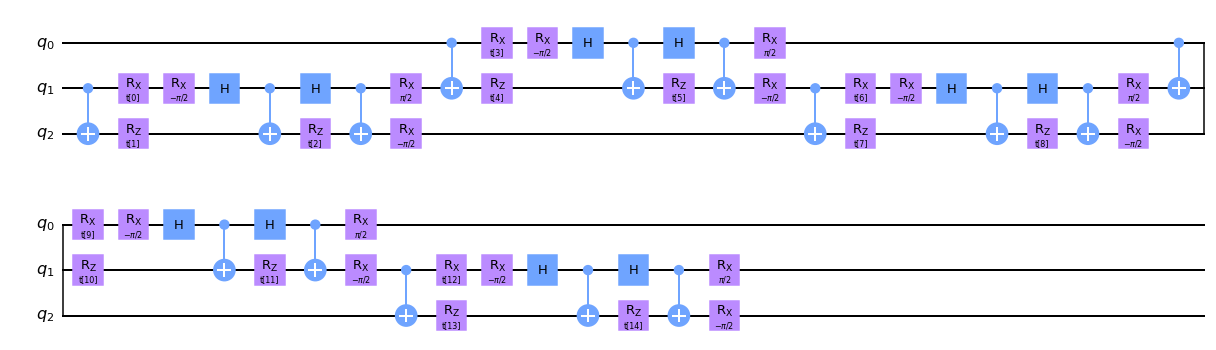

In [16]:
# Here we show an example of the circuit
example = Heisenberg_YBE_variational(ParameterVector('t',15))
example.draw(output='mpl')

At every time $t$, we want the YBE circuit to be equivalent to the Trotter circuit with 4 steps.

We will do so by  finding $\theta_{t}$ that maximizes at every time $t$ the overlap

$$
|\langle \psi_0 |U^{\dagger}_{T}(t)U_{YBE}(\theta_t) |\psi_0\rangle|^2 \,
$$

where $U_{T}(t)$ indicates the 4-steps Trotter-Suzuki circuit, $U_{YBE}(\theta_t)$ is its compressed version with the Yang-Baxter Equation and $|\psi_0\rangle = U_0|000\rangle =|110\rangle$.

To do this on a quantum circuit, we will use the compute-uncompute method which works as follows:

given

$$
|\langle \psi_0 |U^{\dagger}_{T}(t)U_{YBE}(\theta_t) |\psi_0\rangle|^2 = 
\langle 000| U^{\dagger}_0 U^{\dagger}_{YBE}(\theta_t)U_{T}(t)U_0
|000\rangle \langle 000| 
U^{\dagger}_0U^{\dagger}_{T}(t)U_{YBE}(\theta_t)U_0|000\rangle = \langle \psi|P_0|\psi\rangle
$$

we prepare the state $|\psi\rangle = U^{\dagger}_0U^{\dagger}_{T}(t)U_{YBE}(\theta_t)U_0|000\rangle$ and measure the operator $P_{0} =|000\rangle \langle 000|$.

Then, we compute the gradient of this expectation value using the parameter-shift rule \[5,6\] and pass this information to a classical optimizer like ADAM \[7\] to update the YBE parameters $\theta_t$.

Therefore, we need a method to compute this overlap and its gradient, then a method to update the parameters.

---
\[5\] A. Mari et al., *Estimating the gradient and higher-order derivatives on quantum hardware*, [Phys. Rev. A 103 012405](https://doi.org/10.1103/PhysRevA.103.012405)

\[6\] D. Wierichs et al., *General parameter-shift rules for quantum gradients* [Quantum 6, 677](https://quantum-journal.org/papers/q-2022-03-30-677/)

\[7\] Kingma D. P. and Ba J.L. , *Adam: A Method for Stochastic Optimization*, [arXiv:1412.6980](https://doi.org/10.48550/arxiv.1412.6980)

In [17]:
# Here we import the required functions from "optimization_functions.py"
from optimization_functions import adam_gradient, projector_zero, ei

In [18]:
def ybe_overlap_and_gradient(θ_params,state_wfn,θ_t,sampler):
    
    '''
   This function computes the overlap between the wavefunction obtained with 4 Trotter steps at time t
   and the YBE compressed circuit.
   It also computes the gradient with the respect to the YBE parameters, using the parameter-shift rule
    
    Args:
        - θ_params   : Qiskit ParameterVector, to bind θ_t parameters and shifts for gradient
        - state_wfn  : StateFn P_0 @ |ψ> converted by Qiskit Expectator
        - θ_t        : the array of parameters for U_{YBE}(θ_t)
        - sampler    : Qiskit CircuitSampler to sample from the circuit created given the QuantumInstance
        
    Returns:
        - Overlap between U_T(t)|110> and U_{YBE}(θ_t)|110>
        - Gradient with respect to the YBE parameters
    '''

    nparameters = len(θ_t)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(θ_params[:], θ_t.tolist()))]

    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(θ_params[:] , (θ_t  + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(θ_params[:] , (θ_t  - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned and save the results in a list 
    results = []
    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)
        # It's an exact value, no statistical uncertainties
        mean = sampled_op.eval().real
        results.append(mean)
    
    # The first element of the result list is the overlap
    E = results[0]
    g = np.zeros(nparameters)

    # Parameter shift rule to evaluate the gradient components
    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        g[i] = (rplus-rminus)/2.0

    return E,g

In [19]:
## Define quantities for the optimization

# Array of time points for the YBE compression example
ybe_ts = np.linspace(0, np.pi, 50)

# For YBE circuit
ybe_params_vec = ParameterVector('θ',15)
# Initial parameters
ybe_parameters = np.zeros(15)
num_parameters = len(ybe_parameters)

# Parameter for Trotter circuit
t = Parameter("t")

# For the optimization
# Number of parameter optimizations per time step
opt_steps = 600
# Overlap threshold
opt_ths = 0.9995
# P_0 = |000><000|
zero_prj = StateFn(projector_zero(3),is_measurement = True)

In [20]:
## Create QuantumInstance to run the circuit
backend     = Aer.get_backend('statevector_simulator')
instance    = QuantumInstance(backend=backend)
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

<b><font color=#3A5FBC>WARNING :</font></b> The execution of the next cell takes several minutes (up to 13 minutes). 
For convenience, we already provide the result below.

In [24]:
ybe_params = []
print("Starting YBE compression...")

for (t_step,sim_t) in enumerate(ybe_ts):

    # Create the optimization circuit
    # Define the left- hand circuit U_T(t)|110>
    l_ansatz   = QuantumCircuit(3)
    l_ansatz.x([1,2])
    l_ansatz   = l_ansatz.compose(Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,t=t,target_time=sim_t))
    
    # Define the righ-hand circuit U_{YBE}(theta_t)|110>
    r_ansatz   = QuantumCircuit(3)
    r_ansatz.x([1,2])
    r_ansatz   = r_ansatz.compose(Heisenberg_YBE_variational(ybe_params_vec))
    # Create the binding for the parameters
    r_circ     = r_ansatz.assign_parameters({ybe_params_vec: ybe_params_vec})

    total_circ = r_circ+l_ansatz.inverse()
    state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))


    # Initialize step-quantities
    count          = 0
    max_ovp        = 0.01
    new_parameters = ybe_parameters

    # Set the initial values of the moving averages for the ADAM optimizer 
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)
    
    # Optimize the parameters for #opt_step and up to opt_ths
    while max_ovp < opt_ths and count < opt_steps:
        
        count = count +1 

        # Measure energy and gradient
        E,g = ybe_overlap_and_gradient(ybe_params_vec,state_wfn,new_parameters,sampler)

        # Update the parameters using the evaluated gradient and ADAM optimizer
        meas_grad      = np.asarray(g)
        new_parameters = np.asarray(adam_gradient(new_parameters,count,m,v,meas_grad))

        # Save the best set of parameters found for each time-step
        if E > max_ovp:
            max_ovp        = E
            ybe_parameters = new_parameters
    

    ybe_params.append(list(ybe_parameters))
    # Update parameters
    if t_step%10 == 0:
        print('----------------------------------')
        print("Step: ",t_step,", overlap: " ,max_ovp)

print('----------------------------------')
print("YBE compression completed")

Starting YBE compression...
----------------------------------
Step:  0 , overlap:  0.9999999999999992
----------------------------------
Step:  10 , overlap:  0.9995027329509395
----------------------------------
Step:  20 , overlap:  0.999514506617512
----------------------------------
Step:  30 , overlap:  0.9995154730929722
----------------------------------
Step:  40 , overlap:  0.9995120048664665
----------------------------------
YBE compression completed


Now that the optimization is finished, we want to compute the overlap with the target state $|110\rangle$ at every time $t$:

In [21]:
def ybe_probs_target(target,ybe_circ,param_list):
    
    '''
    A function to compute the probability of being in a target state given a YBE circuit.
    
    Args:
        - target     : the target state
        - ybe_circ   : Qiskit parameterized QuantumCircuit
        - param_list : the list of different parameters
        
    Returns:
        The list of probabilities to be in the target state
    '''

    ovlp_list = []
    
    for params in param_list:
        # Create the circuit
        circ   = QuantumCircuit(3)
        circ.x([1,2])
        circ   = circ.compose(ybe_circ(params))
        # Extract the wavefunction at time t
        wfn_t  = CircuitStateFn(circ)
        # Evaluate the overlap with the target state
        ovlp_t = np.abs((~target@wfn_t).eval())**2

        ovlp_list.append(ovlp_t)

    return ovlp_list

In [26]:
probs_110_ybe  = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,ybe_params)

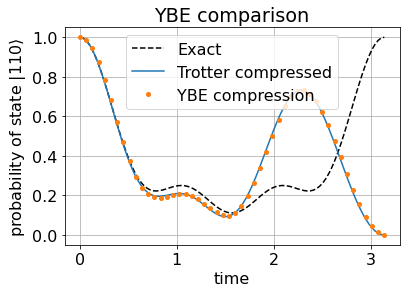

In [27]:
## Now plot the exact simulation, the Trotter compressed and the YBE equivalent
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott_c,color="C0",label="Trotter compressed")
plt.plot(ybe_ts, probs_110_ybe,color="C1",marker=".",linestyle="",label="YBE compression",markersize=8)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'YBE comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, at every time $t$ we are able to find a set of parameters that makes the YBE compressed circuit with $15$ equivalent to the $24$ CNOTs Trotter circuit.

From this moment on, we will be using this circuit for the challenge.

## 2.3 Projected - Variational Quantum Dynamics (pVQD)  <a class="anchor" id="23-projected-variational-quantum-dynamics-pvqd"></a> 

We showed that the YBE circuit is equivalent to the Trotter circuit with 4 Trotter steps.
For this reason, we will have the same accuracy.

We want to increase the representation accuracy of our circuit without increasing the number of gates, that would add more and more noise due to the high error rates.

To this end, we introduce the projected - Variational Quantum Dynamics (pVQD) algorithm \[8\]. 
This method is used to approximate variationally the time evolution of quantum system on quantum computers.

We will use it in a slightly different way: instead of considering a generic variational ansatz, we will use the circuit obtained using the YBE compression and optimize its parameters to improve the accuracy of the simulation, not only for the final time $t=\pi$, but also for the whole simulation.

We highlight that the same technique can be used on the 24 CNOTs Trotterization, with the same results.
However, on hardware the number of CNOTs used will make a big difference on the final fidelity. 

We proceed illustrating the algorithm briefly:

 1. we consider a total simulation time `target_time` and divide it into many discrete time steps of length $dt$
 
 2. for every time step $t$ we want to minimize the cost function 
 $$
 L = \frac{1-|\langle 110|U^{\dagger}_{YBE}(\theta_t +d\theta)U_{T}(dt)U_{YBE}(\theta_t)|110\rangle|^2}{dt^2}
 $$ 
    by optimizing $d\theta$ and, therefore, the overlap in the numerator
 
 3. we use again the compute-uncompute method, preparing $U^{\dagger}_0U^{\dagger}_{YBE}(\theta_t +d\theta)U_{T}(dt)U_{YBE}(\theta_t)U_0|000\rangle$ and measuring $P_0$ as in the YBE compression
 
 4. we use the parameter-shift rule to measure the gradient and optimize $d\theta$.
 
 5. Once the cost function $L$ has converged with $d\theta_{opt}$, we can proceed to the next time step using     $\theta_{t+1} = \theta_t + d\theta_{opt}$.

A sketch of the algorithm from the paper can be found below (here $w = \theta$, but we kept $\theta$ for consistency)

![pvqd_sketch](images/pvqd_sketch_minimized.png)

We note that we are not modifying the Trotter-YBE circuit, instead we are optimizing the same gates in order to make the circuit contain a more accurate state.

---
\[8\] S. Barison et al., *An efficient quantum algorithm for the time evolution of parameterized circuits*, [Quantum 5, 512](https://doi.org/10.22331/q-2021-07-28-512)

As for the YBE compression, we need a function to compute the overlap and its gradient.

The function will be very similar to the old one, with the excpetion that now both the left- and the right-hand circuits will contain parameters.

In [22]:
def pvqd_overlap_and_gradient(θ_l,θ_r,state_wfn,θ_t,dθ,sampler):
    
    '''
   This function computes the overlap between the wavefunction obtained with 4 Trotter steps at time t
   and the YBE compressed circuit.
   It also computes the gradient with the respect to the YBE parameters, using the parameter-shift rule
    
    Args:
        - θ_l        : Qiskit ParameterVector for the left-hand circuit, to bind θ_t+dθ parameters
        - θ_r        : Qiskit ParameterVector for the right-hand circuit, to bind θ_t parameters
        - state_wfn  : StateFn P_0 @ |ψ> converted by Qiskit Expectator
        - θ_t        : the array of parameters for U_{YBE}(θ_t)
        - dθ         : the shift of the parameters between θ_t and θ_{t+1}, to be optimized
        - sampler    : Qiskit CircuitSampler to sample from the circuit created given the QuantumInstance
        
    Returns:
        - Overlap between U_{YBE}(θ_t+dθ)|110> and U_T(dt)U_{YBE}(θ_t)|110>
        - Gradient with respect to dθ
    '''

    nparameters = len(θ_t)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ).tolist()))]


    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(θ_r[:] + θ_l[:], θ_t.tolist() + (θ_t + dθ - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned

    results = []

    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)

        mean  = sampled_op.eval().real
        results.append(mean)


    g = np.zeros(nparameters)
    
    # The first element in the results array is the overlap
    E = results[0]
    
    # Parameter shift rule to evaluate the gradient components
    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        g[i] = (rplus-rminus)/2.0

    return E,g 

In [23]:
# As before, we create the QuantumInstance to run the circuit on the simulator
# and use it to initialize the expectator and the sampler
backend       = Aer.get_backend('statevector_simulator')
instance      = QuantumInstance(backend=backend)
expectation   = PauliExpectation()
sampler       = CircuitSampler(instance)

In [24]:
# Initialize parameters and ParameterVector for the pVQD
θ_t            = np.zeros(15)
num_parameters = len(θ_t)
dθ             = 0.01*np.ones(15)
θ_params_vec   = ParameterVector('θ',num_parameters)

# Different ParameterVector for left and right circuit
θ_l            = ParameterVector('l', num_parameters)
θ_r            = ParameterVector('r', num_parameters)

# Define the evolution time and the time step
dt             = np.pi/60
n_steps        = 60

# Array of time points for the pVQD
pvqd_ts        = [i*dt for i in range(n_steps+1)]

# Parameter for Trotter circuit
t              = Parameter("t")

# Number of optimisation steps and threshold
max_iter       = 100
pvqd_ths       = 0.9999

# Now prepare the state in order to compute the overlap and its gradient
# First use a single compressed Trotter step
U_dt           = Heisenberg_Trotter_compressed(3,1,t,dt)

# The YBE circuit for the pVQD algorithm, initalizing the state at |110>
ansatz         = QuantumCircuit(3)
ansatz.x([1,2])
ansatz         = ansatz.compose(Heisenberg_YBE_variational(θ_params_vec))

# Then, create the total circuit
l_circ         = ansatz.assign_parameters({θ_params_vec: θ_l})
r_circ         = ansatz.assign_parameters({θ_params_vec: θ_r})
zero_prj       = StateFn(projector_zero(U_dt.num_qubits),is_measurement = True)
total_circ     = r_circ.compose(U_dt)+l_circ.inverse()
state_wfn      = expectation.convert(zero_prj @ StateFn(total_circ))

Unlike the YBE equivalence optimization, this cell is fast to execute (less than 2 minutes).

In [25]:
print("Running the pVQD algorithm")

pvqd_params = []
pvqd_params.append(list(θ_t))


for i in range(n_steps):
    
    if i%15 == 0:
        print('----------------------------------')
        print("Time slice:",i)

    count = 0
    E     = 0.01

    # Set the initial values of the moving averages for the ADAM optimizer
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)

    while E < pvqd_ths and count < max_iter:
        
        count = count +1 

        # Measure energy and gradient
        E,g = pvqd_overlap_and_gradient(θ_l,θ_r,state_wfn,θ_t,dθ,sampler)
       
        meas_grad = np.asarray(g)
        dθ        = np.asarray(adam_gradient(dθ,count,m,v,meas_grad))


    # Print the current overlap
    if i%15 == 0:
        print("pVQD overlap: ",E)
    
    #Update parameters
    θ_t = θ_t + dθ
    pvqd_params.append(list(θ_t))
    
print("pVQD: Done, parameter list created")

Running the pVQD algorithm
----------------------------------
Time slice: 0
pVQD overlap:  0.9999002127826854
----------------------------------
Time slice: 15
pVQD overlap:  0.9999091642321721
----------------------------------
Time slice: 30
pVQD overlap:  0.9999054148100901
----------------------------------
Time slice: 45
pVQD overlap:  0.9999051049885351
pVQD: Done, parameter list created


From the pVQD routine we get a list of parameters values.

What we are interested in is the last set of parameters, corresponding to the evolution of the wavefunction at the final time $t=\pi$.

For completeness, we will also plot the probability of getting $|110\rangle$ throught the overall evolution.

In [26]:
probs_110_pvqd = ybe_probs_target(One^One^Zero,Heisenberg_YBE_variational,pvqd_params)

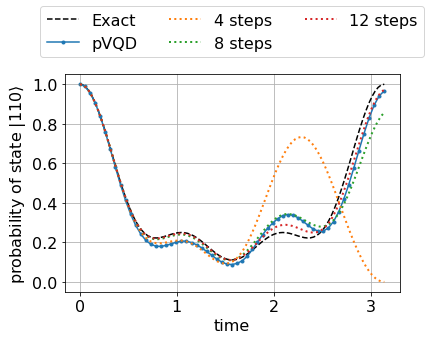

In [27]:
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(pvqd_ts,probs_110_pvqd,label="pVQD",marker=".",color="C0")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i+1),label=str(n)+" steps",linewidth=2,linestyle="dotted")

plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.35),ncol=3,fancybox=True)
plt.grid()
plt.show()

As can be seen, we have an improvement through the whole simulation, not just for the final state.
At $t \sim 1.5$ the Trotter approximation with $4$ steps starts detaching from the exact simulation, while the pVQD stay closer, with performances comparable to the 12 Trotter steps approximation.

We highlight that this technique is completely general: given a Trotter step $U(dt)$ we can compress its repeated application into a variational circuit of choice.

Moreover, this technique can also be performed entirely on hardware, as shown in \[9\].

---
\[9\] N. F. Berthusen et al., *Quantum dynamics simulations beyond the coherence time on NISQ hardware by variational Trotter compressions*, [arXiv:2112.12654](https://arxiv.org/abs/2112.12654)

In [28]:
#Here we show the parameters that we are going to use 
pvqd_final_params = pvqd_params[-1]
pvqd_final_params

[0.638201706904138,
 0.6000000001716403,
 0.6382017069038879,
 3.008803486262198,
 -3.086920031778619,
 0.47095314625605,
 2.1631495814111137,
 3.480816131205721,
 -2.0741264476111265,
 1.23302069446252,
 3.127510077367923,
 1.5937443398205002,
 6.107319842333266,
 3.0177717821835945,
 -3.249018054808095]

In [38]:
# Dump all the parameters and the final optimal configuration in a file using json
log_data = {}
log_data["pvqd_params"]       = pvqd_params
log_data["pvqd_final_params"] = pvqd_final_params

with open("pvqd_logfile.dat","w") as f:
    json.dump(log_data,f)

## 2.4 Error mitigation <a class="anchor" id="24-error-mitigation"></a>

To squeeze the best possible performance out of the current generation of quantum computers researchers
have come up with a variety of different methods to reduce or mitigate the errors that are accumulated during the computation. 

In the following we will use three different strategies to help maximizing the final fidelity that is obtained on the quantum computer.

### 2.4.1 Qubit routing <a class="anchor" id="241--qubit-routing"></a>

When researchers usually design a quantum algorithm they treat the qubits as ideal, noise-free qubits that can be arbitrarily entangled with each other. 
This is however far from reality, on a real quantum computer every qubit is slightly different and gate errors vary quite a lot between different qubits. 
Moreover, not all qubits can directly be entangled with each other. Only the qubits that are physically coupled to each other can directly be entangled. 
In order to entangle qubits that are far apart on the hardware chip, the states between the intermediate qubits have to be swapped with costly SWAP gates (see \[9\] for an overview of these concepts). 

Luckily, in our challenge we need to entangle qubits $1$, $3$ and $5$ which on the Jakarta chip are all directly physically coupled. So we do not need any SWAPs!



Looking at the callibration data from [Jakarta](https://quantum-computing.ibm.com/services?services=systems&system=ibmq_jakarta) we can see that the two qubit error rates are lower between qubit $3$ and $5$ than between $1$ and $3$.
We can use this knowledge to our advantage! 

Due to the YBE compression that we used we have an uneven number of CNOT gates acting on the two qubit pairs. We deliberately choose to use the YBE such that there 
are more CNOT acting on $3$ and $5$ than on $1$ and $3$, since it gives less errors.

![jakarta](images/jakarta.png)

---
\[9\] A. Cowtan et al., *On the qubit routing problem*, [arXiv:1902.08091](https://arxiv.org/abs/1902.08091)

### 2.4.2 Zero Noise Extrapolation (ZNE) <a class="anchor" id="242-zero-noise-extrapolation-zne"></a>

Zero Noise Extrapolation (ZNE) \[11, 12, 13\] is a common tool to estimate what the output would be on a quantum computer without any noise. 
To do this, the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$, so in essence simply inserting the identity (since $G^\dagger G = I$).
The circuit remains the same this way, though the noise level is increased. 
This way we can obtain results for different noise levels and extrapolate to the ideal zero-noise case. 

This prodecure is readily implemented in the popular error mitgation framework [Mitiq](https://mitiq.readthedocs.io/en/stable/from). 
In particular, we will unfold the circuit $1$, $2$, $3$, $4$ and $5$ times and extrapolate the noise level to zero by fitting the counts that are obtained in the tomography to a third order polynomial. 
Written out as an equation we roughly have 
$$
\text{counts}_{\text{bitstring}}(x)=a+bx+cx^2+dx^3,
$$ 
where $x$ is the noise level that is controlled by the number of unfoldings that are used. Once the paramters $a$, $b$ ,$c$ and $d$ are fitted, the expression is evalutated for the zero noise level ($x=0$). Which is then the counts that we use for the fidelity estimation. 

---
\[11\] Y. Li and S. C. Benjamin, *Efficient variational quantum simulator incorporating active error minimisation*, [Phys. Rev. X 7, 021050](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.021050)

\[12\] K. Temme, S. Bravyi and J. M. Gambetta , *Error mitigation for short-depth quantum circuits*, [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)

\[13\] A. Kandala et al., *Extending the computational reach of a noisy superconducting quantum processor*, [Nature 567, 491-495 (2019)](https://www.nature.com/articles/s41586-019-1040-7)

In [29]:
## Mitiq import and helper functions
## WARNING: Use Mitiq version >= 0.11.1, this is required to work with the X gates in the circuit
import re
import copy
from mitiq import zne
from itertools import chain
from qiskit.result import Result
from qiskit.result.models import ExperimentResult
from qiskit.result.models import ExperimentResultData
from qiskit.result.models import QobjExperimentHeader

In [57]:
# The gate unfoldings that we use for ZNE
scale_factors = [1.0, 2.0, 3.0, 4.0, 5.0]

At first, we create a function to perform Zero Noise Extrapolation (ZNE) on results obtainted from either execution on simulated or real hardware.

In [31]:
def zero_noise_extrapolation(job, tomo_circs, shots, scale_factors, zne_order):
    
    '''
    This function takes the result of the unfolded circuits and performs
    Zero Noise Extrapolation (ZNE) on the counts of the different measurement 
    outcomes, i.e. the bitstrings.
    
    Args:
        - result: Qiskit result object that that was obtained by executing the unfolded circuits
        - tomo_circs: The quantum state tomography cirucits
        - shots: Number of measurements 
        - scale_factors: List of integers that controls the unfoldings used for ZNE
        - zne_order: Order of the polynomial that is used for extrapolation to the zero-noise level
        
    Returns:
        Qiskit Result object that contains the ZNE counts, the tomography circuits
    '''
        
    result = job.result()
        
    # Create ordered list of all bitstrings that are observed
    count_list = result.get_counts()
    ordered_bitstrings = dict(sorted(count_list[0].items()))
    zne_result_list = []

    # Loop over the tomography circuits and perform ZNE on the counts for each circuit
    for i in range(len(tomo_circs)):
        counts_dict = {}

        # Loop over the results of the unfolded circuits and collect the data in the correct form
        for key in ordered_bitstrings.keys():
            counts_list_zne = []
            for count in count_list[i*len(scale_factors):len(scale_factors)*(i+1)]:
                counts_list_zne.append(count[key])

            # Here we extrapolate the counts to zero noise and round to the closest integer.
            # This is done using a polynomial of order "zne_order" using the mitiq function PolyFactory 
            zne_counts_value = int(zne.PolyFactory.extrapolate(scale_factors, counts_list_zne, order=zne_order)) 
            
            # The ZNE result can very occationally be slightly negative.
            # Since negative counts are unphysical we set them to zero.  
            if zne_counts_value < 0:
                zne_counts_value = 0
            counts_dict[key] = zne_counts_value
        zne_result_list.append(counts_dict)
        
    # To work with the StateTomographyFitter we need to put the result into a Qiskit Result() object otherwise we get errors
    name_list = [circ.name for circ in tomo_circs]
    results_tmp = [[ExperimentResult(shots=shots, success=True, data=ExperimentResultData(counts=result_i), header=QobjExperimentHeader(name=name_i))] for (name_i, result_i) in zip(name_list, zne_result_list)]
    results = [Result(backend_name="zne", backend_version="zne", qobj_id='0', job_id='0', success=True, results=result_i) for result_i in results_tmp]

    return results
    

For execution on real hardware submitted circuits often spend a considerable time in a queue. It is therefore convenient to split the execution into two functions:

- the `zne_launch` launches the jobs on simulated/real hardware and saves the `JOB_ID` and `JOB` object associated to it
- the `zne_collect` collects the jobs using the corresponding `JOB_ID` or `JOB` list passed to it and performs ZNE on the counts. 

The `JOB_ID` list is used when real hardware was used while the `JOB` list is used when the circuit was executed on a simulator.

With this separation, we can submit the job without being forced to keep the notebook running for as long as the queue of the hardware requires.

In [32]:
def zne_launch(tomo_circs, backend, optimization_level, shots, scale_factors):

    '''
    This function launches the ZNE tomography circuits on real or simultated quantum hardware.
    
    Args:
        - tomo_circs: The quantum state tomography cirucits
        - backend: Backend that is used for the execution (can be real hardware of simulated hardware)
        - optimization_level: Level of circuit optimization that is done before execution on hardware
        - shots: Number of measurements 
        - scale_factors: List of integers that controls the unfoldings used for ZNE
        
    Returns:
        Job id of the launched job and the job
    '''

    # Create list of globally (all gates) unfolded circuits using Mitiq
    noise_scaled_circuits = [[zne.scaling.fold_global(circ, s) for s in scale_factors] for circ in tomo_circs] 
    noise_scaled_circuits = list(chain(*noise_scaled_circuits)) 
    
    # Send circuits to real hardware and retrive the job id
    job = execute(noise_scaled_circuits, backend=backend, optimization_level=optimization_level, shots=shots)
    job_id = job.job_id()

    print("JOB "+str(job_id)+" SUBMITTED")
    
    return str(job_id), job

In [33]:
def zne_collect(real_hardware, backend, tomo_circs, zne_order, shots, scale_factors, job=None, jobid=None):

    '''
    This function retrives the results of the ZNE state tomography circuits after execution on
    real hardware and performs ZNE on the counts for the different bitstrings that are obtained.
    For the ZNE we use a polynomial of order "zne_order".
    
    Args:
        - real_hardware: Boolean variable so define if a real or simulated hardware was used
        - tomo_circs : The quantum state tomography cirucits
        - zne_order: Order of the polynomial that is used for extrapolation to the zero-noise level
        - shots: Number of measurements 
        - scale_factors: List of integers that controls the unfoldings used for ZNE
        
    Returns:
        Qiskit Result object that contains the ZNE counts, the tomography circuits
    '''
    
    if real_hardware:
        # Retrive the results from IBM     
        job = backend.retrieve_job(jobid)
            
    # Execute ZNE
    results = zero_noise_extrapolation(job, tomo_circs, shots, scale_factors, zne_order)
    
    return results

### 2.4.3 Removal of unphysical bitstrings <a class="anchor" id="243-removal-of-unphysical-bitstrings"></a>

There is one last error mitigation that we will use to further improve our results.
In particular, we know that for the Heisenberg model $H_{\text{Heis}}$ the magnetization $M=\sum_i \sigma_i^z$ is a conserved quantity. 
This can be seen from the fact that it commutes with the Hamiltonian 

$$[H_{\text{Heis}}, M]=0.$$ 
The initial state $|110\rangle$ that we time evolve has a magnetization of $\langle M \rangle =-1$ since two spins are in the $1$ state, since 

$$\langle 0 | \sigma_z | 0 \rangle = 1 \, \, \, \text{and} \, \, \, \langle 1 | \sigma_z | 1 \rangle = -1 \, .
$$ 

The magnetization $M$ thus has to be conserved during our time evolution. 
This allows us to remove some unphysical bitstrings that are obtained due to hardware noise in the tomography (a similar technique was recently used in \[14\]). 

In the state tomography local basis changes (using Clifford gates) are performed to obtain the counts in the $x$, $y$ and $z$-basis.
There are two types of circuits for which we can remove unphysical bitstrings:

1. The one where **all** qubits are measured in the $z$-basis
2. and the ones where **two** qubits are measured in the $z$-basis. 
   
For the first we know that bitstrings with either all qubits in the $1$ state or all qubits in the $0$ state are unphysical since they give a magnetization of $-3$ and $3$, respectively. 
For the second circuit type we know that for both the qubits that are measured in the $z$-basis the qubits cannot both be in the $0$ state since the remaining qubit that is measured in a different basis, regardless of its state, is not enough to obtain a total magnetization of $-1$. In total there are 7 circuits for which we can set uphysical counts to zero.

---
\[14\] J. Vovrosh and J. Knolle, *Confinement and entanglement dynamics on a digital quantum computer*, [Scientific Reports 11, 11577 (2021)](https://www.nature.com/articles/s41598-021-90849-5#:~:text=Confinement%20describes%20the%20phenomenon%20when,chromodynamics%20(QCD)%20between%20quarks)


In [34]:
def remove_unphysical_bitstrings(result):

    '''
    This function removes the unphysical bitstrings that are obtained in the tomography measurement.
    Counts for bitstrings that are not consistent with the conservation of magnetization are set to zero. 
    
    Args:
        - result : The Qiskit Result object containing the counts for the state tomography 
        
    Returns:
        Qiskit Result object where the unphyiscal counts are set to zero
    '''

    # Loop over the result that is obtained from the tomography 
    # and remove the bitstrings that violate the conservation of the magnetization
    result_physical = copy.copy(result)
    for i in range(len(result_physical)):
        name = result_physical[i].results[0].header.name
        res = "".join(re.findall("[XYZ]+", name))
        res_2 = "".join(re.findall("[Z]+", res))
        
        # Set unphysical bitstrings to zero if all qubits are measured in the z-basis
        if len(res_2) == 3:
            bitstring_1 = res.replace('Z', '0')
            bitstring_2 = res.replace('Z', '1')
            result_physical[i].results[0].data.counts[bitstring_1] = 0
            result_physical[i].results[0].data.counts[bitstring_2] = 0

         # Set unphysical bitstrings to zero if two qubits (out of three) are measured in the z-basis
        if len(res_2) == 2:    
            bitstring = res.replace('Z', '0')
            bitstring_1 = bitstring.replace('X', '0')
            bitstring_1 = bitstring_1.replace('Y', '0')
            bitstring_2 = bitstring.replace('X', '1')
            bitstring_2 = bitstring_2.replace('Y', '1')
            result_physical[i].results[0].data.counts[bitstring_1] = 0
            result_physical[i].results[0].data.counts[bitstring_2] = 0

    return result_physical

# 3 Execution  <a class="anchor" id="3-execution"></a>

Finally, after all of this work we are ready to run the circuit and measure the fidelity!

In [35]:
# For convenience we load the pVQD parameters here again.
pvqd_file = json.load(open("pvqd_logfile.dat","r"))
pvqd_final_params = pvqd_file["pvqd_final_params"]

In [36]:
# Define the final circuit that is used to compute the fidelity 
fqr = QuantumRegister(7)
fqc = QuantumCircuit(fqr)
# Note that in an earlier version of Mitiq, X gates were not supported for unfolding. 
# Therefore, in earlier hardware runs we had to use Rx(pi), which is iX, the fidelity remains uneffected
fqc.x([3, 5]) #  Use Mitiq >= 0.11.1 to put X gates in the initialization circuit
fqc.id([0, 1, 2, 4, 6]) # We need to put identities since Mitiq cannot handle unused qubits
fqc.append(Heisenberg_YBE_variational(pvqd_final_params), [fqr[1], fqr[3], fqr[5]])

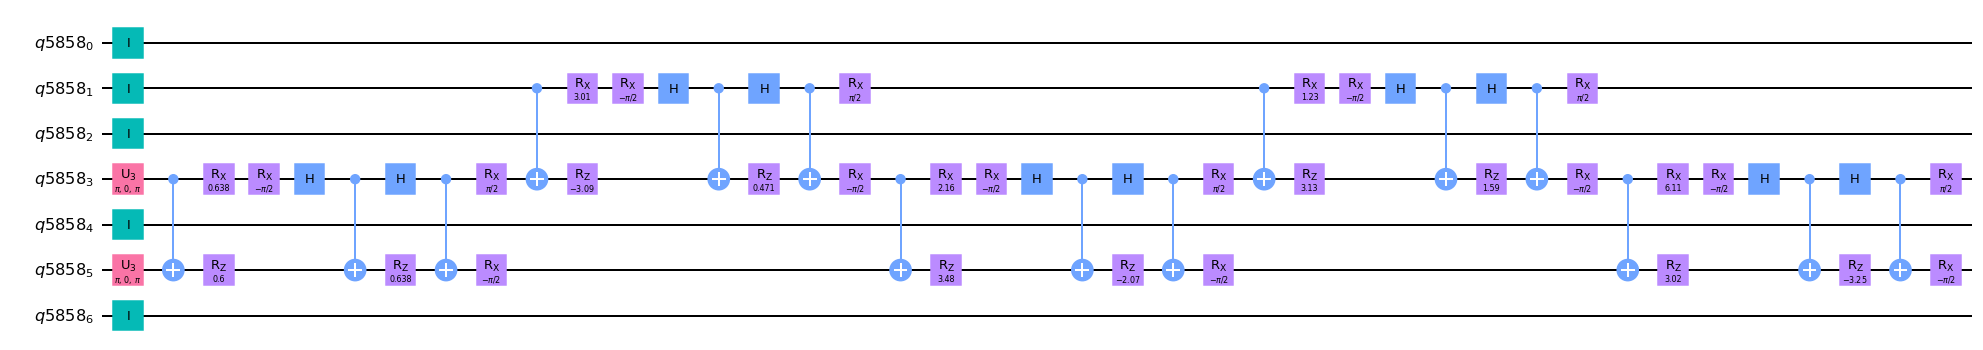

In [40]:
# Draw the the circuit for which we will perform full state tomography
fqc.decompose().draw(output="mpl",fold=-1)

In [41]:
## Import functions that are needed for the tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [42]:
# Load up the IBMQ account
provider = IBMQ.load_account()

In [43]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [44]:
# Create the tomography circuits
st_qcs = state_tomography_circuits(fqc.decompose(), [fqr[1], fqr[3], fqr[5]])

Finally, the function given in the challenge notebook, to compute the state tomography of the circuit

In [45]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

## 3.1 - On noisy simulator <a class="anchor" id="31-noisy-simulator"></a>

First, we test our method using a simulator with the noise model of the Jakarta backend.

### 3.1.1 Submit jobs  <a class="anchor" id="311-submit-jobs"></a>

In [46]:
# Setting the number of shots and backend 
shots = 8192
backend = sim_noisy_jakarta

In [47]:
sim_jobs = []
sim_reps = 8

# Launch the execution of the state tomography circuits
for count in range(sim_reps):
    print("\n REPETITION: ",count)
    jobid, job = zne_launch(tomo_circs=st_qcs,backend=backend,optimization_level=0,
                                    shots=shots, scale_factors=scale_factors)
    sim_jobs.append(job)


 REPETITION:  0
JOB 10b24a4e-6ca3-41d2-87f6-5e6949b864fc SUBMITTED

 REPETITION:  1
JOB 7f6e6c3a-c282-4969-85cd-95098c337f1c SUBMITTED

 REPETITION:  2
JOB 83760adc-95a7-46c1-866c-184943af5d86 SUBMITTED

 REPETITION:  3
JOB 5bae0d80-74bd-42e7-8504-d209ffef8635 SUBMITTED

 REPETITION:  4
JOB 22b6ce78-029a-4eb0-ab72-8cc4b1c4bf37 SUBMITTED

 REPETITION:  5
JOB 58b98627-077b-4491-8cd0-a56ebf2dc32c SUBMITTED

 REPETITION:  6
JOB 51df0077-3c3f-4a78-b6e8-f329d569fe70 SUBMITTED

 REPETITION:  7
JOB 17d079ee-c562-4f5b-99c1-87bbf5d3cdb8 SUBMITTED


### 3.1.2 Collect results and compute fidelity <a class="anchor" id="312-collect-results-and-compute-fidelity"></a>

In [48]:
sim_fids = []

# Loop over the 8 fidelity measurements, perform error mitigation on the counts 
# and compute the fidelity for every experiment
for count, job in enumerate(sim_jobs):
    print("\nCOLLECT SIMULATION: ",count)
    zne_res = zne_collect(real_hardware=False, backend=backend, jobid=job,tomo_circs=st_qcs,
                                             zne_order=3, shots=shots, scale_factors=scale_factors, job=job)
    zne_res_physical = remove_unphysical_bitstrings(zne_res)
    sim_fids.append(state_tomo(zne_res_physical, st_qcs))


COLLECT SIMULATION:  0

COLLECT SIMULATION:  1

COLLECT SIMULATION:  2

COLLECT SIMULATION:  3

COLLECT SIMULATION:  4

COLLECT SIMULATION:  5

COLLECT SIMULATION:  6

COLLECT SIMULATION:  7


In [49]:
# Print the final result
print('Noisy simulator state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(sim_fids), np.std(sim_fids)))

Noisy simulator state tomography fidelity = 0.9401 ± 0.0117


## 3.2 - On hardware <a class="anchor" id="32-hardware"></a>

Now that we have tested our method on simulator, we can finally submit jobs on hardware!

### 3.2.1 Submit jobs  <a class="anchor" id="321-submit-jobs"></a>

In [50]:
# Setting the number of shots and backend 
shots = 8192
backend = jakarta

<b><font color=#3A5FBC>WARNING :</font></b> The next cell submit jobs on Jakarta hardware

In [53]:
# Repeat fidelity measurement 8 times
reps = 8 
ibm_job_ids = []
    
# Now launch the jobs
for count in range(reps):
    print("\n REPETITION "+str(count+1)+"\n")
    job_id, job = zne_launch(tomo_circs=st_qcs, backend=backend, optimization_level=0, shots=shots,
                                scale_factors=scale_factors)
    ibm_job_ids.append(job_id)

In [ ]:
# Display the JOB_ID list
ibm_job_ids

In [93]:
# These are the jobids of the runs on hardware that we submit as a solution
ibm_job_ids = ['623f2b1ed97bffed4c69508b',
'623f2b3f0af65dbf3dd93d91',
'623f2b60d97bff7ce369508f',
'623f2b8219e6894babc81713',
'623f2ba309995c2ba64932af',
'623f2bc374de0ec93f85b846',
'623f2be4d97bff59ad695094',
'623f2c058293e94ac21e66d4']

### 3.2.2 Collect results and compute fidelity <a class="anchor" id="322-collect-results-and-compute-fidelity"></a>

In [55]:
ibmq_fids = []
# Loop over the 8 fidelity measurements, perform error mitigation on the counts 
# and compute the fidelity for every experiment
for count, jobid in enumerate(ibm_job_ids):
    print("\n COLLECT HARDWARE RESULT: ",count)
    zne_res = zne_collect(real_hardware=True, backend=backend, tomo_circs=st_qcs,
                                             zne_order=3, shots=shots, scale_factors=scale_factors, jobid=jobid)
    zne_res_physical = remove_unphysical_bitstrings(zne_res)
    ibmq_fids.append(state_tomo(zne_res_physical, st_qcs))


 COLLECT HARDWARE RESULT:  0

 COLLECT HARDWARE RESULT:  1

 COLLECT HARDWARE RESULT:  2

 COLLECT HARDWARE RESULT:  3

 COLLECT HARDWARE RESULT:  4

 COLLECT HARDWARE RESULT:  5

 COLLECT HARDWARE RESULT:  6

 COLLECT HARDWARE RESULT:  7


In [56]:
# Print the final result
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(ibmq_fids), np.std(ibmq_fids)))

state tomography fidelity = 0.8032 ± 0.0203


This notebook has been created with the following Qiskit version:

In [51]:
import qiskit.tools.jupyter
%qiskit_version_table